In [1]:
import tensorflow as tf
tf.__version__
import tqdm
import glob
from absl import flags
import os
import pathlib
import numpy as np

# triplet generation

In [ ]:
def pair_parser(imgs):
    # Note y_true shape will be [batch,3]
    return (imgs[0], imgs[1], imgs[2]),([1,1,2])
def processOneDir4(basedir,ext):
    list_ds = tf.data.Dataset.list_files(basedir+"/*."+ext).shuffle(100).repeat()
    return list_ds
def generateTriplet(imgs,label):
    labels = [int(tf.strings.split(imgs[0],os.path.sep)[0,-2]),int(tf.strings.split(imgs[1],os.path.sep)[0,-2]),int(tf.strings.split(imgs[2],os.path.sep)[0,-2])]
    return (imgs),(labels)
    
dbdir = "../data/split"
allsubdir = [os.path.join(dbdir, o) for o in os.listdir(dbdir) 
                    if os.path.isdir(os.path.join(dbdir,o))]
path_ds = tf.data.Dataset.from_tensor_slices(allsubdir)
ds = path_ds.interleave(lambda x: processOneDir4(x,'jpg'), cycle_length=5751,
                  block_length=2,
                  num_parallel_calls=4).batch(4, True).map(pair_parser, -1).batch(1, True).map(generateTriplet, -1)
iters = iter(ds)

In [20]:
cnt=0
total=0
for i in range(2):
    imgs, label = next(iters)
    print(imgs[0],label[0])
    print(imgs[1],label[1])
    print(imgs[2],label[2])
    print("**********")
   

tf.Tensor([b'..\\data\\split\\0\\37.jpg'], shape=(1,), dtype=string) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor([b'..\\data\\split\\0\\105.jpg'], shape=(1,), dtype=string) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor([b'..\\data\\split\\1\\129.jpg'], shape=(1,), dtype=string) tf.Tensor(1, shape=(), dtype=int32)
**********
tf.Tensor([b'..\\data\\split\\10\\712.jpg'], shape=(1,), dtype=string) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor([b'..\\data\\split\\10\\758.jpg'], shape=(1,), dtype=string) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor([b'..\\data\\split\\100\\7278.jpg'], shape=(1,), dtype=string) tf.Tensor(100, shape=(), dtype=int32)
**********


# just pairs

In [48]:
def _transform_images(is_ccrop=False):
    def transform_images(x_train):
        x_train = tf.image.resize(x_train, (128, 128))
        x_train = tf.image.random_crop(x_train, (112, 112, 3))
        x_train = tf.image.random_flip_left_right(x_train)
        x_train = tf.image.random_saturation(x_train, 0.6, 1.4)
        x_train = tf.image.random_brightness(x_train, 0.4)
        x_train = x_train / 255
        return x_train
    return transform_images

def ListFiles(basedir,ext):
    list_ds = tf.data.Dataset.list_files(basedir+"/*."+ext).repeat()
    return list_ds
def pair_parser(imgs,totalsamples, dataset='VGG2'):
    images = imgs
    labels = []
    if dataset == 'VGG2':
        for i in range(totalsamples):
            labels.append(tf.strings.to_number( tf.strings.substr(tf.strings.split(imgs[None,i], os.path.sep)[0, -2], pos=1, len=6), out_type=tf.dtypes.int32))
    else:
        for i in range(totalsamples):
            labels.append(tf.strings.to_number( tf.strings.split(imgs[None,i],os.path.sep)[0,-2], out_type=tf.dtypes.int32))
    return images,labels

def preprocess_image(image,totalsamples):
    images = []
    for i in range(totalsamples):
        img = tf.image.decode_jpeg(image[i], channels=3)
        img = _transform_images(is_ccrop=False)(img)
        images.append(img)
    return images

def load_and_preprocess_image(path,labels,totalsamples):
    image = []
    for i in range(totalsamples):
        image.append(tf.io.read_file(path[i]))
    return preprocess_image(image,totalsamples),labels
    
dbdir = "../data/split"
ext = 'jpg'
dataset_ext = 'ms'# VGG2
allsubdir = [os.path.join(dbdir, o) for o in os.listdir(dbdir) 
                    if os.path.isdir(os.path.join(dbdir,o))]
path_ds = tf.data.Dataset.from_tensor_slices(allsubdir)
# block_length how many samples per class
samples_per_class = 3
# how many classes for each batch
classes_per_batch = 4
ds = path_ds.shuffle(10240).interleave(lambda x: ListFiles(x,ext), cycle_length=tf.data.experimental.AUTOTUNE,
                  block_length=samples_per_class,
                  num_parallel_calls=8).batch(classes_per_batch*samples_per_class, True).map(lambda x:pair_parser(x,classes_per_batch*samples_per_class,dataset=dataset_ext), -1).map(lambda path,labels: load_and_preprocess_image(path,labels,classes_per_batch*samples_per_class), num_parallel_calls=tf.data.experimental.AUTOTUNE)
iters = iter(ds)

                  block_length=samples_per_class,
                  num_parallel_calls=8).batch(classes_per_batch*samples_per_class, True).map(lambda x:pair_parser(x,classes_per_batch*samples_per_class,dataset=dataset_ext), -1).map(lambda path,labels: load_and_preprocess_image(path,labels,classes_per_batch*samples_per_class), num_parallel_calls=tf.data.experimental.AUTOTUNE)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
                  block_length=samples_per_class,
                  num_parallel_calls=8).batch(classes_per_batch*samples_per_class, True).map(lambda x:pair_parser(x,classes_per_batch*samples_per_class,dataset=dataset_ext), -1).map(lambda path,labels: load_and_preprocess_image(path,labels,classes_per_batch*samples_per_class), num_parallel_calls=tf.data.experimental.AUTOTUNE)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate ex

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


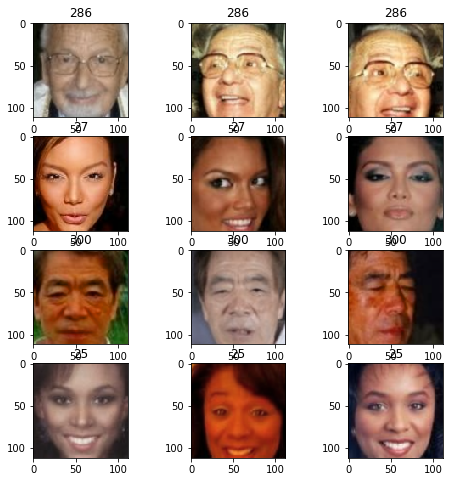

In [49]:
import matplotlib.pyplot as plt

cnt=0
total=0
for i in range(1):
    inputs, labels = next(iters)
    plt.figure(figsize=(8,8))
    for n, image in enumerate(inputs):
        ax = plt.subplot(4,3,n+1).set_title(int(labels[n]))
        plt.imshow(image)
#         plt.suptitle(int(labels[n]))
        
#         print(labels[n])
    plt.show()
    
   